# **Initial Configuration and Setup**

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/MyProjects/DigitRecognizer


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/MyProjects/DigitRecognizer'
/content


In [2]:
# Install Kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"angelagyang","key":"a29eb7fe2a3acf36b6564128d835d32d"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the data
%mkdir data
%cd data 
!kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘data’: File exists
/content/data
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:

import sys
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils.rnn import *
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torch.autograd import Variable

import time
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv("train.csv")
print(train[:2])

# Normalize the data 
X = train.loc[:,train.columns != "label"].values/255
Y = train.label.values

features_train, features_test, targets_train, targets_test = train_test_split(X,Y,test_size=0.2,
                                                                              random_state=24)
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)

Y_train = torch.from_numpy(targets_train).type(torch.LongTensor) 
Y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train,Y_train)
test = torch.utils.data.TensorDataset(X_test,Y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle = False)

   label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0

[2 rows x 785 columns]


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.out = nn.Linear(64, 10) 
        
    def forward(self,x): 
        out = self.cnn_1(x)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = self.cnn_2(out)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.out(out)
        
        return out

In [21]:
model = CNN()
model = model.double()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [24]:
epochs = 15
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = model(train)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = model(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/15..  Training Loss: 0.271..  Test Loss: 0.081..  Test Accuracy: 0.975
Epoch: 2/15..  Training Loss: 0.119..  Test Loss: 0.068..  Test Accuracy: 0.978
Epoch: 3/15..  Training Loss: 0.101..  Test Loss: 0.066..  Test Accuracy: 0.979
Epoch: 4/15..  Training Loss: 0.098..  Test Loss: 0.056..  Test Accuracy: 0.981
Epoch: 5/15..  Training Loss: 0.089..  Test Loss: 0.052..  Test Accuracy: 0.983
Epoch: 6/15..  Training Loss: 0.086..  Test Loss: 0.052..  Test Accuracy: 0.985
Epoch: 7/15..  Training Loss: 0.081..  Test Loss: 0.051..  Test Accuracy: 0.986
Epoch: 8/15..  Training Loss: 0.081..  Test Loss: 0.051..  Test Accuracy: 0.986
Epoch: 9/15..  Training Loss: 0.074..  Test Loss: 0.065..  Test Accuracy: 0.985
Epoch: 10/15..  Training Loss: 0.075..  Test Loss: 0.055..  Test Accuracy: 0.982
Epoch: 11/15..  Training Loss: 0.070..  Test Loss: 0.050..  Test Accuracy: 0.986
Epoch: 12/15..  Training Loss: 0.075..  Test Loss: 0.047..  Test Accuracy: 0.986
Epoch: 13/15..  Training Loss: 0.074.

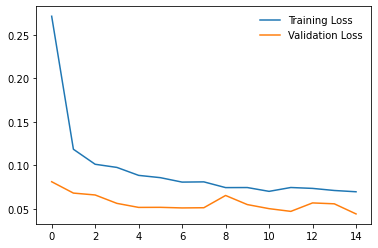

In [25]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)

# **Inference**

In [26]:
inferencedata = pd.read_csv("test.csv")
inference_X = inferencedata.loc[:,inferencedata.columns != "label"].values/255
inference_dataset = torch.from_numpy(inference_X)
inference_loader = torch.utils.data.DataLoader(inference_dataset, batch_size = 100, shuffle = False)

In [28]:
# Run the trained model
results = []
with torch.no_grad():
    model.eval()
    for images in inference_loader:
        test = Variable(images.view(-1,1,28,28))
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.numpy().tolist()

In [31]:
# Output submissions
predictions = np.array(results).flatten()
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submission.csv", index=False, header=True)

In [32]:
# Submit to kaggle 
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Submitting predictions!"

100% 208k/208k [00:00<00:00, 799kB/s]
Successfully submitted to Digit Recognizer